In [85]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import Row, SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
conf = SparkConf()
conf.setAppName('highway').setMaster('local[*]')

sc = SparkContext(conf = conf)
spark = SparkSession(sc)

先以5/28一天的資料來進行分析，首先讀取5/28的資料

In [24]:
data = sc.textFile('d:/code/highway/data/20180528/*')
data.take(3)

['32,2018-05-28 00:14:37,01F0664S,2018-05-28 00:15:36,01F0681S,4.200,Y,2018-05-28 00:14:37+01F0664S; 2018-05-28 00:15:36+01F0681S',
 '32,2018-05-28 00:05:58,01F3561S,2018-05-28 00:05:58,01F3561S,6.800,Y,2018-05-28 00:05:58+01F3561S',
 '32,2018-05-28 00:17:24,01F0557N,2018-05-28 00:45:02,01H0200N,38.200,Y,2018-05-28 00:17:24+01F0557N; 2018-05-28 00:19:15+01F0532N; 2018-05-28 00:21:03+01F0509N; 2018-05-28 00:24:19+01F0467N; 2018-05-28 00:28:33+01F0413N; 2018-05-28 00:31:22+01F0376N; 2018-05-28 00:34:13+01F0339N; 2018-05-28 00:39:29+01H0271N; 2018-05-28 00:44:26+01H0208N; 2018-05-28 00:45:02+01H0200N']

為了避免原始資料不完整導致程式出錯，先進行簡單的篩選。接著只留下需要的欄位。首先針對通過的閘門數進行分析:

In [25]:
day_count = data.filter(lambda x : len(x) > 30).map(lambda x : x.split(',')).map(lambda x : Row(car = x[0], day = x[1].split(' ')[0],count = len(x[7].split(';')))).toDF()
day_count.registerTempTable('traffic')

將處理過的資料轉為Pandas的dataframe進行統計並繪圖

In [27]:
day_dist = spark.sql('select day, count, sum(count) as c from traffic group by day, count').toPandas()

新增一個欄位，判斷是否通過超過一個欄位以上，最後繪成圓餅圖

In [66]:
day_dist['is_great_than_1'] = day_dist['count'].apply(lambda x : 'Y' if x > 1 else 'N')
agg_day_dist = day_dist.groupby('is_great_than_1', as_index = False)['is_great_than_1','c'].sum()


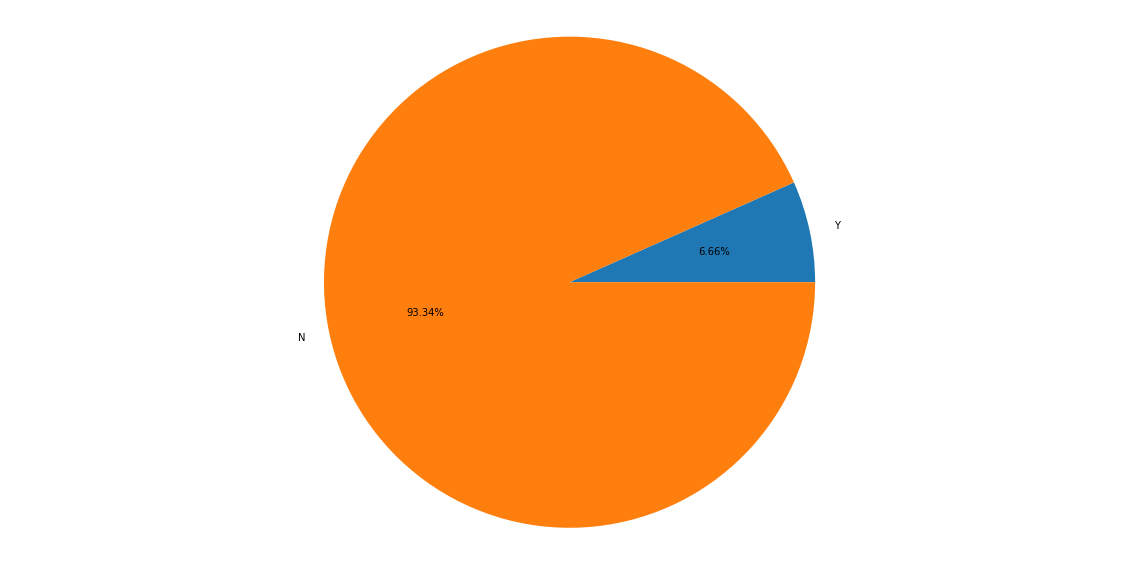

In [77]:
labels = ['Y','N']
plt.figure(figsize = (20,10))
plt.pie(x = agg_day_dist['c'], labels = labels, autopct='%1.2f%%')
plt.axis('equal')
plt.show()

看起來不到10%的交通量只通過一個收費閘門，也就是說，如果取出通過時間與閘門距離計算，超過90%的交通量都可以得到通過每個區段的平均時速。所以接著來計算如果採用新的方法取締超速的話，一天可以增加多少的交通罰單收入

In [80]:
cars_pass_many_gates = data.filter(lambda x : len(x) > 30).map(lambda x : x.split(',')).filter(lambda x : len(x[7].split(';')) > 1).map(lambda x : x[0]+','+x[1].split(' ')[0]+','+x[7])

不過因為有太多閘門了，所以這邊只取了最熟悉的大溪到龍潭、龍潭到關西服務區這段來進行分析。這兩個閘門的距離用高速公路里程計算的話應該是五公里

In [96]:
def GetGate(data):
    gate_list = data.split(';')
    target_gate = {}
    for gate in gate_list:
        if '03F0648S' in gate or '03F0698S' in gate:
            time = gate.strip().split('+')[0]
            gate = gate.strip().split('+')[1]
            target_gate[gate] = time
    speed = GetSpeed(target_gate)
    return speed

In [88]:
def ConvertTime(time):
    #2018-05-28 00:45:02
    conv_t = datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
    return conv_t.timestamp()

In [101]:
def GetSpeed(data):
    t_start = ConvertTime(data['03F0648S'])
    t_end = ConvertTime(data['03F0698S'])
    t_diff = (t_end - t_start) / 1000.0
    distance = 5.0
    speed = (5.0 * 3600.0 ) / (t_diff * 1000.0)
    return speed

統計一整天有通過這兩個閘門的交通量，有36151個車次通過這個區間

In [94]:
cars_pass_certain_gate = cars_pass_many_gates.filter(lambda x : '03F0648S' in x and '03F0698S' in x).map(lambda x : x.split(','))
len(cars_pass_certain_gate.collect())

36151

In [103]:
cars_with_speed = cars_pass_certain_gate.map(lambda x : Row(cars = x[0], day = x[1], speed = GetGate(x[2]))).toDF().toPandas()

國道三號這個區間的速限是110km/h，有上限10公里的緩衝，所以超過120km/h就算是超速了，新增一個是否超速的欄位

In [104]:
cars_with_speed['over_speed'] = cars_with_speed['speed'].apply(lambda x : 'Y' if x > 120 else 'N')

統計這一天內有多少車次是超速的，結果統計出來有2468個車次是超過最高速的

In [105]:
cars_with_speed[cars_with_speed['over_speed'] == 'Y'].size

2468

檢視一下速度的統計分配情況，結果看到一個時速為-2的，看起來應該是資料內容有問題，至於最高時速有到174km/h，雖然誇張不過也不是不可能

In [106]:
cars_with_speed['speed'].describe()

count    36151.000000
mean        96.127663
std         16.895509
min         -2.643172
25%         90.452261
50%         98.360656
75%        105.882353
max        174.757282
Name: speed, dtype: float64

統計完超速的車次量，接著來計算如果用這些資料去取締超速的話，一天可以開出多少罰單金額。首先上網查了一下，對於超過速限不同範圍有不同的罰則，所以寫了條件判斷去計算超速的罰款金額

In [124]:
def GetFineLevel(speed):
    if speed > 120 and speed <= 140:
        return 1
    elif speed > 140 and speed <= 160:
        return 2
    elif speed > 160 and speed <= 180:
        return 3
    elif speed > 180 and speed <= 200:
        return 4
    elif speed > 200 and speed <= 220:
        return 5
    elif speed > 220:
        return 6

In [125]:
def GetFine(speed, car):
    fine = 0
    if car.startswith('3') :
        level = GetFineLevel(speed)
        if level == 1:
            fine = 3000
        elif level == 2:
            fine = 3500
        elif level == 3:
            fine = 5000
        elif level == 4:
            fine = 8000
        elif level == 5:
            fine = 12000
        elif level == 6:
            fine = 24000
    else:
        level = GetFineLevel(speed)
        if level == 1:
            fine = 3500
        elif level == 2:
            fine = 4500
        elif level == 3:
            fine = 6000
        elif level == 4:
            fine = 12000
        elif level == 5:
            fine = 16000
        elif level == 6:
            fine = 24000
    return fine

接著新增罰款欄位，如果超速的話就計算需要付多少罰金，如果沒有超速的話罰款金額就是0

In [126]:
cars_with_speed['fine'] = cars_with_speed.apply(lambda row: GetFine(int(row['speed']), row['cars']) if row['over_speed'] == 'Y' else 0, axis = 1)

接著看本日最速車輛，看來要被開5000塊的罰單

In [127]:
cars_with_speed[cars_with_speed['speed']  > 170]

,cars,day,speed,over_speed,fine
1330,31,2018-05-28,174.757282,Y,5000


如果是一天可以收入的罰單金額呢? 算起來是滿驚人的: 這個路段一天可以開出165萬的罰單。根據統計資料，106年國道警察共開出295047筆超速罰單，平均一天是808張罰單。用這個方法取締超速的話，光這個路段一天就2400張以上的罰單了...

In [129]:
cars_with_speed['fine'].sum()

1656000

這個超速的狀況究竟是常態，還是只是特例呢? 為了檢視這個分析資料是否具有代表性，這邊拿了從4/20到6/2號的高公局資料來進行分析(其中5/22、5/23資料源因為部分有問題，有些時段資料是空值)

In [131]:
month_data = sc.textFile('hdfs://master:54310/rawdata/highway_raw/*')
month_data.take(2)

['32,2018-04-20 00:18:57,01F0557N,2018-04-20 00:46:20,01H0200N,38.200,Y,2018-04-20 00:18:57+01F0557N; 2018-04-20 00:20:51+01F0532N; 2018-04-20 00:22:40+01F0509N; 2018-04-20 00:25:56+01F0467N; 2018-04-20 00:30:09+01F0413N; 2018-04-20 00:33:03+01F0376N; 2018-04-20 00:35:51+01F0339N; 2018-04-20 00:40:55+01H0271N; 2018-04-20 00:45:43+01H0208N; 2018-04-20 00:46:20+01H0200N',
 '42,2018-04-20 00:04:17,01F3696N,2018-04-20 02:06:05,01F1839N,189.000,Y,2018-04-20 00:04:17+01F3696N; 2018-04-20 00:05:38+01F3676N; 2018-04-20 00:07:53+01F3640N; 2018-04-20 00:11:04+01F3590N; 2018-04-20 00:13:04+01F3559N; 2018-04-20 00:15:17+01F3525N; 2018-04-20 00:19:34+01F3460N; 2018-04-20 00:23:40+01F3398N; 2018-04-20 00:25:53+01F3366N; 2018-04-20 00:31:00+01F3286N; 2018-04-20 00:33:12+01F3252N; 2018-04-20 00:34:48+01F3227N; 2018-04-20 00:37:30+01F3185N; 2018-04-20 00:41:21+01F3126N; 2018-04-20 00:44:05+01F3083N; 2018-04-20 00:48:08+01F3019N; 2018-04-20 00:53:51+01F2930N; 2018-04-20 00:57:56+01F2866N; 2018-04-20 01:

跟統計一天的資料方法是一樣的，先將資料簡化，再取出需要的欄位，最後計算是否有超速的行為

In [148]:
month_car_pass_many_gates = month_data.filter(lambda x : len(x) > 30).map(lambda x : x.split(',')).filter(lambda x : len(x[7].split(';')) > 1).filter(lambda x : '03F0648S' in x[7] and '03F0698S' in x[7]).map(lambda x : x[0]+','+x[1].split(' ')[0]+','+x[1].split(' ')[1]+','+x[7])
month_car_df = month_car_pass_many_gates.map(lambda x : x.split(',')).map(lambda x : Row(car = x[0], day=x[1], time = x[2], speed = GetGate(x[3]))).toDF().toPandas()

In [149]:
month_car_df['over_speed'] = month_car_df['speed'].apply(lambda x : 'Y' if x > 120 else 'N')
month_car_df[month_car_df['over_speed'] == 'Y'].size

107725

In [150]:
month_car_df['fine'] = month_car_df.apply(lambda row: GetFine(int(row['speed']), row['car']) if row['over_speed'] == 'Y' else 0, axis = 1)
month_car_df['fine'].sum()

58008500

可以看到這一個多月的時間，可以開出107725張超速罰單，罰單金額為5800萬元。接著來看超速情況是否會因為日期不同而有不同的分布情況:

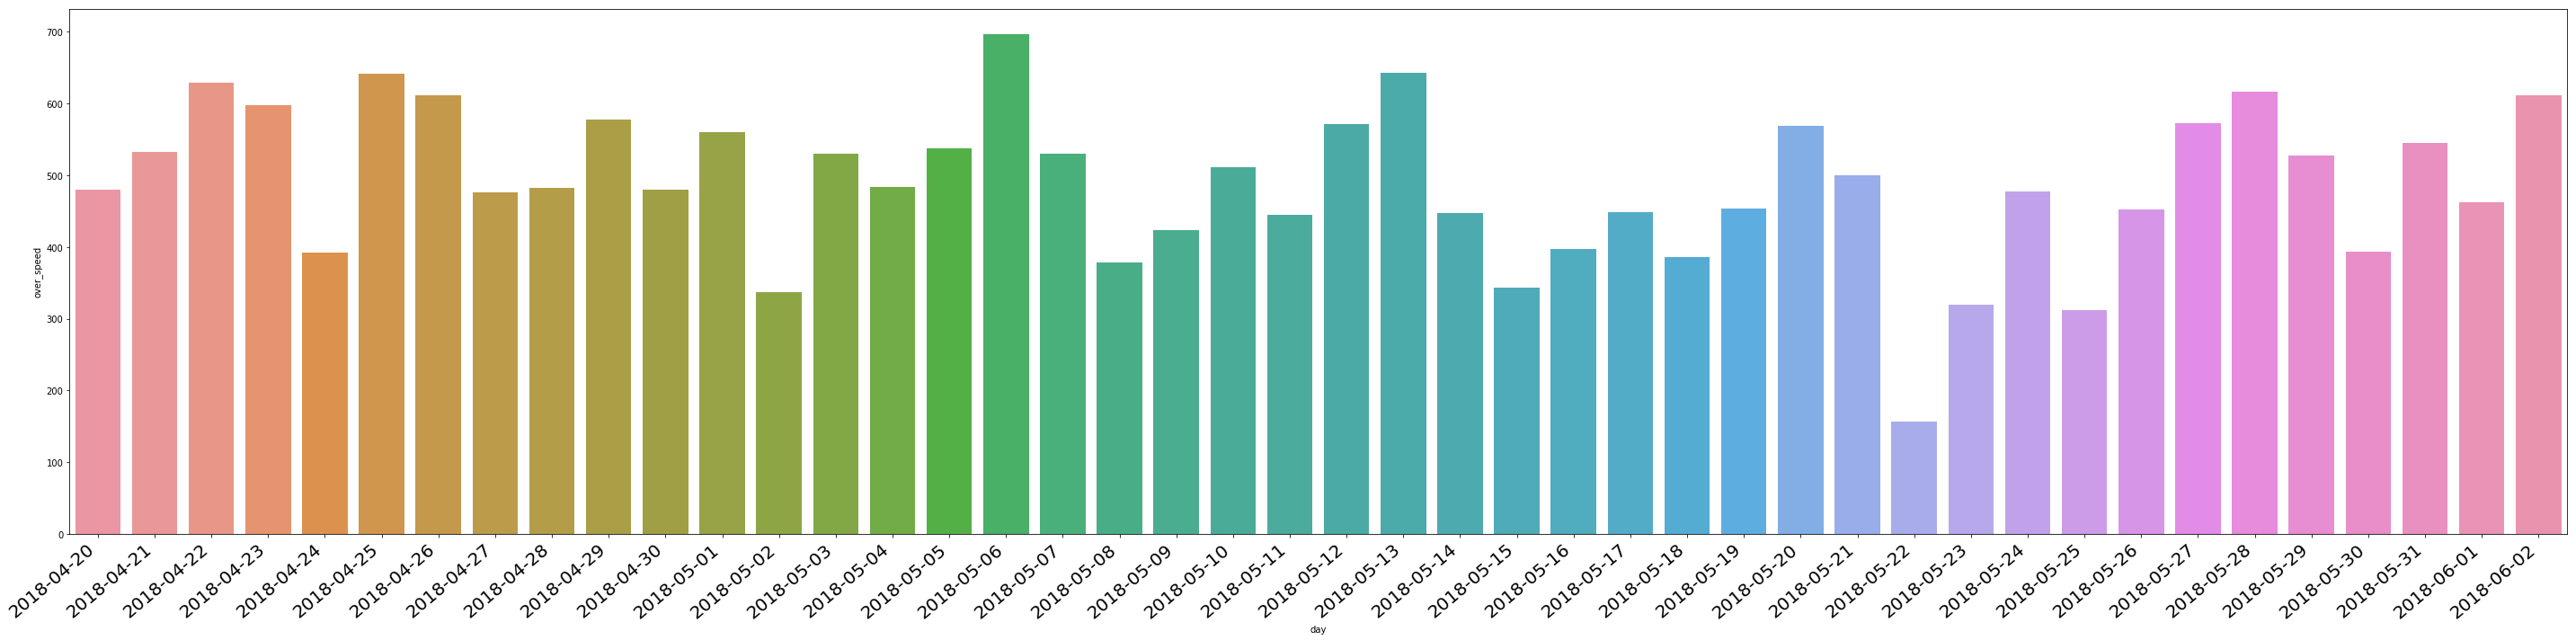

In [168]:
over_speed_day_count = month_car_df[month_car_df['over_speed'] == 'Y'].groupby('day', as_index = False)['over_speed'].count()
plt.figure(figsize = (40,10))
g = sns.barplot(x = 'day', y = 'over_speed', data = over_speed_day_count)
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right',fontsize=20)
plt.tight_layout()
plt.show()

從日期的分布來看，大約看的出來每天的狀況是有點不太一樣的: 從上面的圖表中可以大略看出一個星期中超速案件最少的是星期天，而最多的是星期五，不知道是不是跟星期天比較容易塞車的狀況有關，而星期五駕駛人可能比較會有趕著回家或出遊而開快車的狀況。

除了用日期統計超速件數之外，接著用日期統計超速案件總罰金:

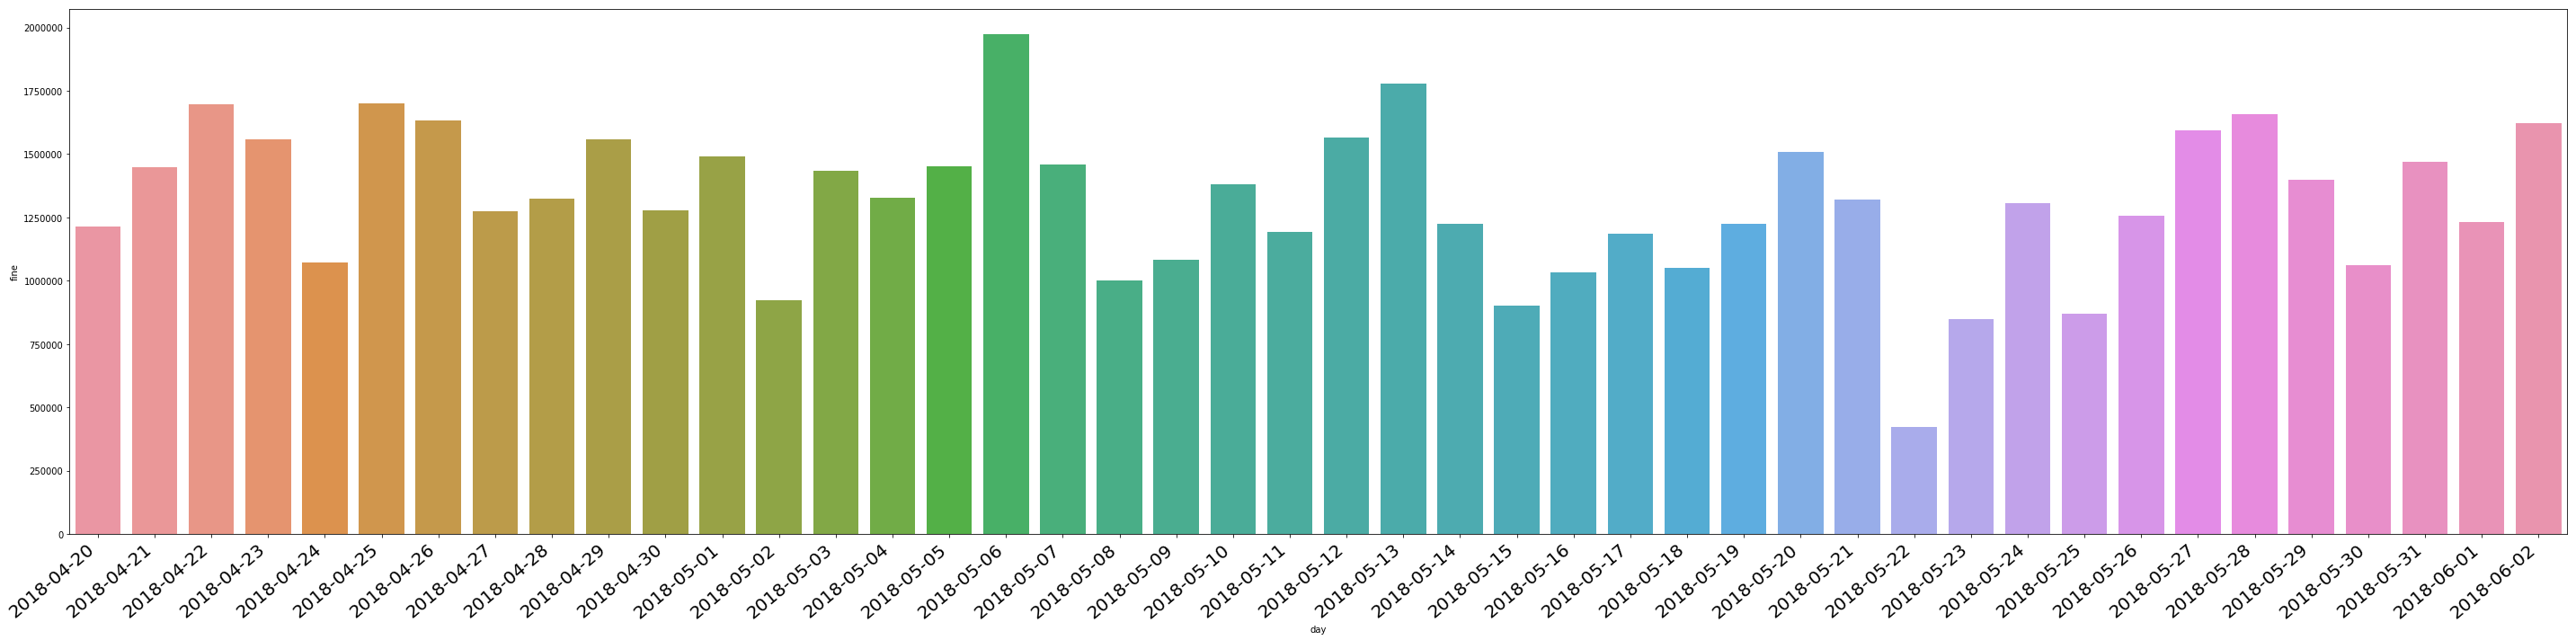

In [169]:
over_speed_day_fine = month_car_df.groupby('day', as_index= False)['day','fine'].sum()
plt.figure(figsize = (40,10))
g = sns.barplot(x = 'day',y = 'fine',data = over_speed_day_fine)
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right",fontsize=20)
plt.tight_layout()
plt.show()

罰金的分布狀況大致於超速案件的分布接近(聽起來有點像廢話)

看了以上的好處(對政府來說)，但是這些資料真的是乾淨可用的嗎?(看看上面的時速居然有-2的情況出現)。所以針對這些超速案件，來看看極端情況是如何:

In [151]:
month_car_df[month_car_df['fine'] == month_car_df['fine'].max()]

,car,day,speed,time,over_speed,fine
1078239,42,2018-05-14,692.307692,15:33:55,Y,24000


看到這邊，我也是醉了: 居然有時速接近700公里的車輛出現，比台灣高鐵還厲害了，而且還是大貨車，不說我還以為是飛機咧。為了檢視原始資料是否就已經出錯，這邊撈出5/14的原始資料來看看:

In [154]:
data_may = sc.textFile('hdfs://master:54310/rawdata/highway_raw/20180514/')
data_may_f = data_may.map(lambda x : x.split(',')).filter(lambda x : x[0] == '42' and x[1] == '2018-05-14 15:33:55' and len(x[7].split(';')) > 1 and '03F0648S' in x[7] and '03F0698S' in x[7])
data_may_f.take(5)

[['42',
  '2018-05-14 15:33:55',
  '03F0648S',
  '2018-05-14 15:35:29',
  '03F0698N',
  '21.400',
  'Y',
  '2018-05-14 15:33:55+03F0648S; 2018-05-14 15:34:21+03F0698S; 2018-05-14 15:35:29+03F0698N']]

看起來原始的資料就是這樣了: 不到一分鐘開了五公里的路程，然後再來個帥氣大迴轉由南下轉為北上，這大概只有超人做得到吧...

小結: 雖然這個方法理論上是可行的，不過在現在的資料中看起來還是有很多的雜質，例如速度計算出來過高或過低，或是數值不合理的部分，這些都有待解決，不然駕駛人收到這種取締的罰單除了不知道錯在哪之外，也只能默默的花錢消災吧...